# 1. Setup

In [ ]:
# import json
# from datetime import date, time

# import colorcet as cc
# import holidays
# import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
# import matplotlib.transforms as mt
import numpy as np
import pandas as pd
# import plotly.express as px
# import plotly.graph_objects as go
import seaborn as sns
# from IPython.display import Image
# from matplotlib.dates import DateFormatter, MonthLocator
# from matplotlib.lines import Line2D
# from matplotlib.ticker import MultipleLocator
# from pandas.core.groupby.generic import DataFrameGroupBy
# from prophet import Prophet
# from scipy.ndimage import binary_dilation
# from shapely.geometry import shape
# from statsmodels.tsa.seasonal import MSTL, seasonal_decompose

In [ ]:
pd.set_option(
    "display.float_format",
    lambda x: f"{x:.2e}" if abs(x) < 0.01 and x != 0 else f"{x:.2f}",
)
pd.set_option('display.max_columns', 100)
pd.set_option("display.max_rows", 100)

In [ ]:
SEGMENT_C = ["county", "product_type", "is_business"]
CATEGORICAL_C = ["county", "product_type", "is_business", "is_consumption"]
TARGET_C = [
    "county",
    "product_type",
    "is_business",
    "is_consumption",
    "datetime",
]
RAND = 10

In [ ]:
RAW_DATA_PATH = "../raw_data/"
ADDITIONAL_DATA_PATH = "../additional_data/"

In [ ]:
from utils.loading import load_all_raw_data
from utils.preprocessing import process_all_dfs
from utils.merging import merge_all_dfs

In [ ]:
from utils.feature_engineering import (
    get_lag,
    get_moving_average,
    add_cyclic_datetime_features,
)

# 2. Processing

In [ ]:
processed_dfs = process_all_dfs(
    load_all_raw_data(RAW_DATA_PATH, ADDITIONAL_DATA_PATH)
)

In [ ]:
processed_dfs.keys()

dict_keys(['train', 'gas_prices', 'client', 'electricity_prices', 'forecast_weather', 'historical_weather', 'station_county_mapping', 'county_id_to_name_map', 'holidays'])

In [ ]:
df = merge_all_dfs(processed_dfs)

In [ ]:
for lag in [2, 3, 7]:
    df = df.merge(
        get_lag(processed_dfs["train"][TARGET_C + ["target"]], lag=lag),
        on=TARGET_C,
    )

In [ ]:
df = add_cyclic_datetime_features(df)

In [ ]:
for window in [24, 24 * 3, 24 * 7]:
    df = df.merge(
        get_moving_average(
            processed_dfs["train"]
            .set_index("datetime")
            .sort_index()
            .groupby(CATEGORICAL_C, observed=True, as_index=False),
            window=window,
        ).dropna(),
        on=TARGET_C,
    )

In [ ]:
(
    processed_dfs["train"]
    .set_index("datetime")
    .sort_index()
    .groupby(CATEGORICAL_C, observed=True, as_index=False)
)["target"].dtype

,county,product_type,is_business,is_consumption,target
0,0,0,True,False,float32
1,0,0,True,True,float32
2,0,1,False,False,float32
3,0,1,False,True,float32
4,0,1,True,False,float32
...,...,...,...,...,...
133,15,1,True,True,float32
134,15,3,False,False,float32
135,15,3,False,True,float32
136,15,3,True,False,float32


In [ ]:
# df.shape

In [ ]:
# df.head()

In [ ]:
df.dtypes

county                                        category
product_type                                  category
is_business                                       bool
is_consumption                                    bool
datetime                                datetime64[ns]
target                                         float32
data_block_id                                   uint16
date                                            object
dst                                               bool
eic_count                                       uint32
installed_capacity                             float32
lowest_price_per_mwh                           float32
highest_price_per_mwh                          float32
euros_per_mwh                                  float32
f1_temperature                                 float32
f1_dewpoint                                    float32
f1_snowfall                                    float32
f1_total_precipitation                         float32
f1_cloudco

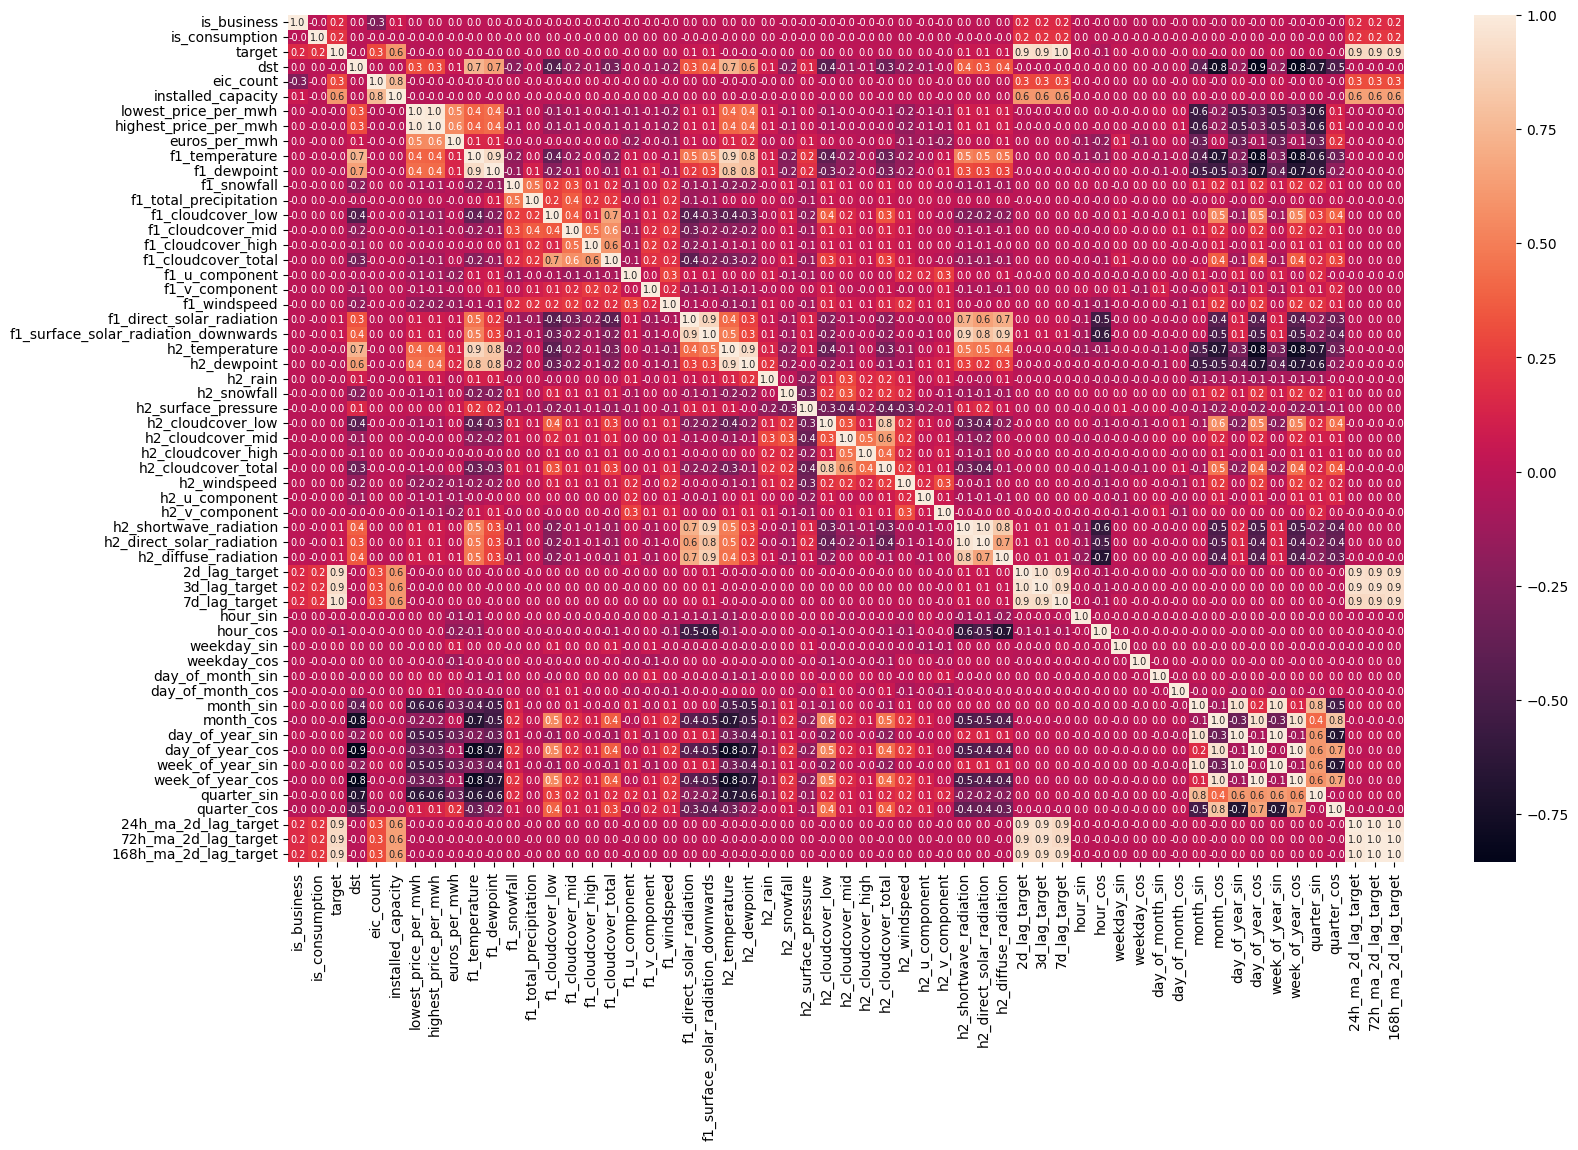

In [ ]:
plt.figure(figsize=(18, 11))
sns.heatmap(
    df.drop(
        columns=[
            "county",
            "product_type",
            "datetime",
            "data_block_id",
            "date",
            "holiday_type"
        ]
    ).corr(),
    annot=True,
    fmt=".1f",
    annot_kws={"size": 7}
)
plt.show()